In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import h5py
import seaborn as sns
from scipy.special import logit
from scipy.special import expit
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import entropy
from pylab import rcParams
import sys
import torch
import scipy
import corner
import copy
import matplotlib.transforms

import sys
sys.path.append('../../')
from populations.bbh_models import read_hdf5
import populations.bbh_models as read_models
from populations.Flowsclass_dev import FlowModel
from populations.utils.bounded_Nd_kde import Bounded_Nd_kde
from populations import gw_obs

/data/wiay/2297403c/conda_envs/amaze/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
chi_b = [0.0,0.1,0.2,0.5]
alpha_CE = [0.2,0.5,1.0,2.,5.]

In [3]:
flow_kde_KL= np.load('CE_flow_KDE_KL.npy')
kde_flow_KL= np.load('CE_KDE_flow_KL.npy')

'dx = 0/72.; dy = -20/72. \noffsety = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)\nfor label in ax.yaxis.get_ticklabels():\n    label.set_transform(label.get_transform() + offsety)\ndxx = -20/72.; dyx = 0/72.\noffsetx = matplotlib.transforms.ScaledTranslation(dxx, dyx, fig.dpi_scale_trans)\nfor label in ax.xaxis.get_ticklabels():\n    label.set_transform(label.get_transform() + offsetx)'

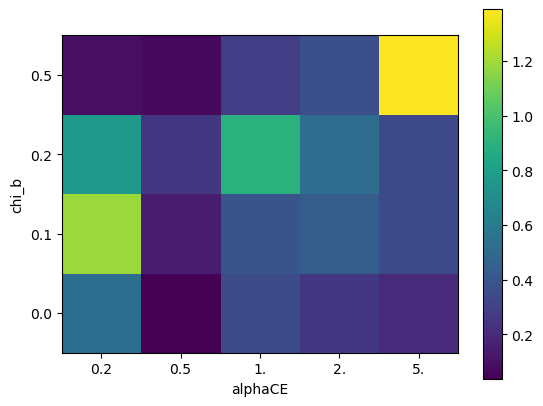

In [4]:
fig,ax=plt.subplots(1,1)
plt.imshow((flow_kde_KL+kde_flow_KL)/2, origin='lower')
plt.colorbar()
#plt.title(r'CE KDE -1/N $\sum$ w(x)p(x)')
plt.xlabel('alphaCE')
plt.ylabel('chi_b')

ax.set_yticks([0,1,2,3])
ax.set_yticklabels(chi_b)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(['0.2','0.5','1.','2.', '5.'])
"""dx = 0/72.; dy = -20/72. 
offsety = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.yaxis.get_ticklabels():
    label.set_transform(label.get_transform() + offsety)
dxx = -20/72.; dyx = 0/72.
offsetx = matplotlib.transforms.ScaledTranslation(dxx, dyx, fig.dpi_scale_trans)
for label in ax.xaxis.get_ticklabels():
    label.set_transform(label.get_transform() + offsetx)"""

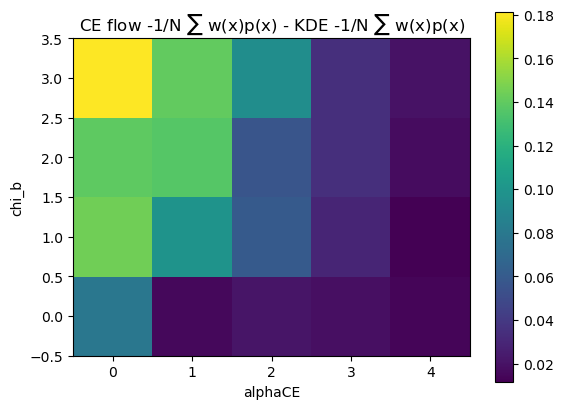

In [5]:

diff= np.load('CE_flow_KL_minus_KDE_KL.npy')
plt.imshow(diff, origin='lower')
plt.colorbar()
plt.title(r'CE flow -1/N $\sum$ w(x)p(x) - KDE -1/N $\sum$ w(x)p(x)')
plt.xlabel('alphaCE')
plt.ylabel('chi_b')

ax.set_yticks([0,1,2,3])
ax.set_yticklabels(chi_b)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(['0.2','0.5','1.','2.', '5.'])
dx = 0/72.; dy = -20/72. 
offsety = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.yaxis.get_ticklabels():
    label.set_transform(label.get_transform() + offsety)
dxx = -20/72.; dyx = 0/72.
offsetx = matplotlib.transforms.ScaledTranslation(dxx, dyx, fig.dpi_scale_trans)
for label in ax.xaxis.get_ticklabels():
    label.set_transform(label.get_transform() + offsetx)

In [16]:
diff

array([[-0.05038761, -0.00062243, -0.0071522 , -0.0051058 , -0.00901989],
       [-0.33620543, -0.00577596, -0.01586889, -0.005572  , -0.00523542],
       [-0.12127537, -0.01382121, -0.01415134, -0.00337175, -0.02479862],
       [-0.20176006, -0.02136494, -0.00564392, -0.01294908, -0.03988227]])

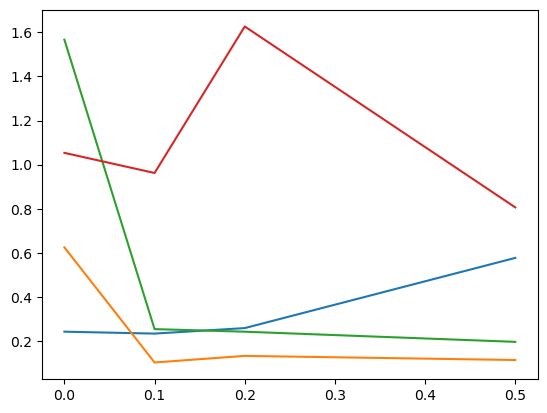

In [6]:
for channel in ['CHE', 'GC', 'NSC', 'SMT']:
    flow_kde_KL= np.load(f'{channel}_flow_KDE_KL.npy')
    kde_flow_KL= np.load(f'{channel}_KDE_flow_KL.npy')

    plt.plot(chi_b, (flow_kde_KL+kde_flow_KL)/2)

[-0.06397332  0.55772647  0.92187533  0.89098426]
[-8.01489270e-08  2.57740721e-07  5.02203944e-07  4.73053327e-07]
[-4.12086713e-10  1.23234898e-09  2.45765705e-09  7.16568882e-09]
[-0.00109825  0.0197954   0.01975981  0.0168154 ]


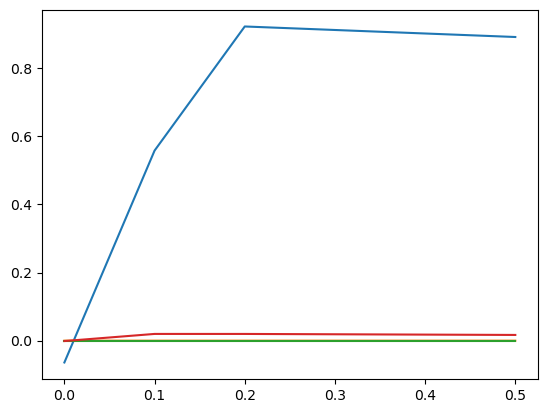

In [7]:
for channel in ['CHE', 'GC', 'NSC', 'SMT']:
    print(np.load(f'{channel}_flow_KL_minus_KDE_KL.npy'))
    plt.plot(chi_b, np.load(f'{channel}_flow_KL_minus_KDE_KL.npy'))

## Test log_probs

In [7]:
models_path ='/data/wiay/2297403c/models_reduced.hdf5'
channel_label='CE'
params = ['mchirp','q', 'chieff', 'z']

popsynth_outputs = read_hdf5(models_path, channel_label) # read all data from hdf5 file
models_dict = dict.fromkeys(popsynth_outputs.keys())
weights_dict = dict.fromkeys(popsynth_outputs.keys())
for key in popsynth_outputs.keys():
    models_dict[key] = popsynth_outputs[key][params]
    weights_dict[key]= popsynth_outputs[key]['weight']

#initialise flow and KDE models
model_names, flow = read_models.get_models(models_path, [channel_label], params, use_flows=True, device='cuda:0', no_bins=[5])
_, KDE = read_models.get_models(models_path, [channel_label], params, use_flows=False, device='cpu')

  0%|          | 0/20 [00:00<?, ?it/s]OMP: Warning #96: Cannot form a team with 44 threads, using 42 instead.
OMP: Hint Consider unsetting KMP_DEVICE_THREAD_LIMIT (KMP_ALL_THREADS), KMP_TEAMS_THREAD_LIMIT, and OMP_THREAD_LIMIT (if any are set).
100%|██████████| 20/20 [03:24<00:00, 10.23s/it]


NameError: name 'args' is not defined

In [8]:
flow_path="/data/wiay/2297403c/amaze_model_select/AMAZE_model_selection/flow_models/mixedmodels_0924/"
flow[channel_label].load_model(flow_path, channel_label)

CE 164


In [9]:

#get model names for grabbing KDE models
hyperparams = list(set([x.split('/', 1)[1] for x in model_names]))
Nhyper = np.max([len(x.split('/')) for x in hyperparams])
# construct dict that relates submodels to their index number
submodels_dict = {} #dummy index dict keys:0,1,2,3, items: particular models
ctr=0 #associates with either chi_b or alpha (0 or 1)
while ctr < Nhyper:
    submodels_dict[ctr] = {}
    hyper_set = sorted(list(set([x.split('/')[ctr] for x in hyperparams])))
    for idx, model in enumerate(hyper_set): #idx associates with 0,1,2,3,(4) keys
        submodels_dict[ctr][idx] = model
    ctr += 1

In [27]:
no_samples=100
model_samples = np.zeros((4,5,no_samples,4))
model_weights = np.zeros((4,5,no_samples))

for chi_b_id, xb in enumerate(chi_b):
    for alpha_id, a in enumerate(alpha_CE):
        model_samples_idx = np.random.choice(np.shape(models_dict[(chi_b_id,alpha_id)])[0], no_samples)#, \
            #p=weights_dict[(chi_b_id,alpha_id)]/np.sum(weights_dict[(chi_b_id,alpha_id)]))
        model_samples[chi_b_id,alpha_id,:,:] = np.array(models_dict[(chi_b_id,alpha_id)])[model_samples_idx]
        model_weights[chi_b_id,alpha_id,:] = np.array(weights_dict[(chi_b_id,alpha_id)])[model_samples_idx]

In [28]:

#cacluate flow||models and KDE||models given the model observations
flow_KL = np.zeros((4,5))
KDE_KL = np.zeros((4,5))
for chi_b_id, xb in enumerate(chi_b):
    for alpha_id, a in enumerate(alpha_CE):
        p_flow = flow[channel_label](np.reshape(model_samples[chi_b_id,alpha_id],(no_samples,1,4)), np.array([xb,np.log(a)]), 990903)
        flow_KL[chi_b_id,alpha_id] = -np.mean(model_weights[chi_b_id,alpha_id]*p_flow)
        p_kde = KDE[channel_label][submodels_dict[0][chi_b_id]][submodels_dict[1][alpha_id]](np.reshape(model_samples[chi_b_id,alpha_id],(no_samples,1,4)), 990903)
        KDE_KL[chi_b_id,alpha_id] = -np.mean(model_weights[chi_b_id,alpha_id]*np.log(p_kde))
        print(-np.mean(p_flow-np.log(p_kde)))


[  0.25291015  -0.92461576   2.63106592  -5.74829487  -2.58684629
  -3.03274063   5.31586361  -0.69162936   4.28189851  -8.11935579
  -2.71398595  -5.39972376  -0.80462117  -6.28954179   0.28183912
  -1.30112373  -0.15443499  -3.2722083    1.71661419  -3.83111258
  -5.16343694  -5.01752344  -9.08630512  -7.90211418  -3.64408376
  -8.58186271  -0.63257463   0.98289355   2.87935     -3.5855921
   1.72391647   4.13171388   4.8133297   -2.81247962   0.66033123
  -4.00897093  -3.78733567  -2.74378042   3.45094255  -3.6630528
   4.68121959  -0.85053643   3.24961738  -2.60478419  -1.3170877
  -1.09353015  -7.83838163  -1.49615481   3.29138426  -3.1893161
  -7.64941743  -4.60455679  -0.66567088 -10.33510463  -5.29486615
  -5.65652671   5.88217306  -0.50005705  -2.99017616 -11.04419126
  -4.02430372  -9.64069214  -0.4053664   -3.14821467  -2.5414744
   2.1902424   -1.99455473  -5.95852695  -0.37692126  -0.17935018
  -0.74575837   3.04255896  -1.51276321   2.47778901  -1.68755033
  -3.53211814  

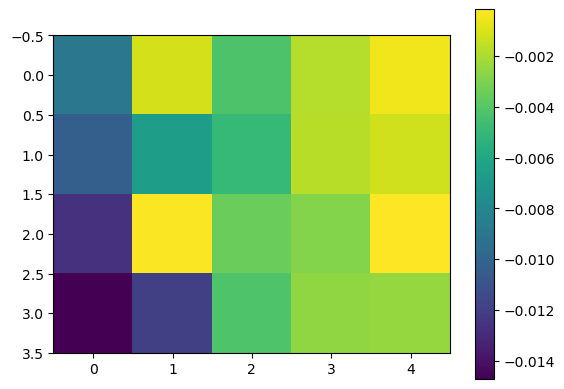

In [31]:
plt.imshow(flow_KL-KDE_KL)
plt.colorbar()